In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import gaitFunctions
from gaitFunctions import swingTimingProportions, adjust_lightness, colorBoxplot
import combineClips
import plotClip
import os
import glob
import seaborn as sns
from scipy import stats
import cv2

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#703391'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# Box plots: offsets (others below)

In [3]:
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries/03 step_kinematics')
excel_filename = 'iw_30Jan_tardigrade01_exemplaris_037-058.xlsx'
movie_file = 'iw_30Jan_tardigrade01_exemplaris_037-058.mov'
step_df = pd.read_excel(excel_filename, sheet_name='step_timing', index_col=None)
step_df.head(3)

,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,distance_during_step,distance_during_step_scaled,cruising_during_step,average_tardigrade_area,average_tardigrade_length,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change
0,L1,3.090,4.181,1.091,0.243,1.334,0.8178,4.3025,L1:0.9089,R1:0.057;0.6589,...,50.084031,0.052280,True,11394.875000,213.564508,NaN,0.819,NaN,NaN,NaN
1,L1,4.424,5.393,0.969,0.213,1.182,0.8198,5.4995,L1:0.9099,R1:0.6155,...,44.569661,0.046524,True,11274.625000,212.690571,NaN,0.485,NaN,NaN,NaN
2,L1,5.606,6.333,0.727,0.242,0.969,0.7503,6.4540,L1:0.8751,R1:0.4061,...,37.085644,0.038712,True,11414.833333,216.344908,NaN,0.545,NaN,NaN,NaN


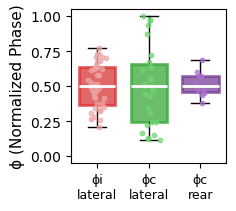

In [4]:
# get ipsilateral offsets normalized to gait cycle
ipsi_reflegs = ['L3','R3','L2','R2']
ipsi_complegs = ['L2','R2','L1','R1']
ipsi_offsets = []
ipsi_proportions = []
ipsi_speeds = []

for i, ref_leg in enumerate(ipsi_reflegs):
    comp_leg = ipsi_complegs[i]
    ipsi_offsets, ipsi_proportions, ipsi_speeds = swingTimingProportions(ipsi_offsets, 
                                                          ipsi_proportions, 
                                                          ipsi_speeds,
                                                          step_df, ref_leg, comp_leg)

# get contralateral offsets normalized to gait cycle FOR LEFT LATERAL LEGS
contra_reflegs = ['L3','L2','L1']
contra_complegs = ['R3','R2','R1']
contra_offsets = []
contra_proportions = []
contra_speeds = []

for i, ref_leg in enumerate(contra_reflegs):
    comp_leg = contra_complegs[i]
    contra_offsets, contra_proportions, contra_speeds = swingTimingProportions(
                                                          contra_offsets, 
                                                          contra_proportions, 
                                                          contra_speeds,
                                                          step_df, ref_leg, comp_leg)

# get contralateral offsets normalized to gait cycle FOR LEFT REAR LEGS
rear_reflegs = ['L4']
rear_complegs = ['R4']
rear_offsets = []
rear_proportions = []
rear_speeds = []

for i, ref_leg in enumerate(rear_reflegs):
    comp_leg = rear_complegs[i]
    rear_offsets, rear_proportions, rear_speeds = swingTimingProportions(
                                                          rear_offsets, 
                                                          rear_proportions, 
                                                          rear_speeds,
                                                          step_df, ref_leg, comp_leg)    

f,ax = plt.subplots(figsize=(2,2))
ax, bp = colorBoxplot(ax,[ipsi_proportions, contra_proportions, rear_proportions],
                  [ipsi_color, contra_color, rear_leg_color],10)

ax.set_ylim([-0.05,1.05])
# ax.legend([bp['boxes'][0], bp['boxes'][1], bp['boxes'][2]], 
#           ['ϕi lateral', 'ϕc lateral','ϕc rear'], loc='lower right', fontsize=12)
# ax.set_xlim([0.8,1.2])
ax.set_ylabel('ϕ (Normalized Phase)', fontsize=axis_fontsize)
ax.set_xticks([1,2,3],['ϕi\nlateral', 'ϕc\nlateral','ϕc\nrear'], fontsize=tick_fontsize)
plt.show()

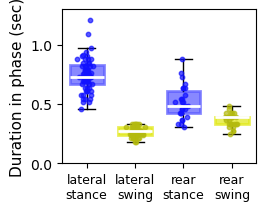

In [5]:
# box plots for stance and swing
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
lateral_stances = step_df[step_df.legID.isin(lateral_legs)]['stance'].values
lateral_swings = step_df[step_df.legID.isin(lateral_legs)]['swing'].values
rear_stances = step_df[step_df.legID.isin(rear_legs)]['stance'].values
rear_swings = step_df[step_df.legID.isin(rear_legs)]['swing'].values

f,ax = plt.subplots(figsize=(2.5,2))
ax, bp = colorBoxplot(ax, [lateral_stances, lateral_swings,rear_stances, rear_swings], 
                      [stance_color, swing_color, stance_color, swing_color],
                      10, 0.8)
ax.set_xticks([1,2,3,4],['lateral\nstance','lateral\nswing','rear\nstance','rear\nswing'],
              fontsize=tick_fontsize)
ax.set_ylabel('Duration in phase (sec)', fontsize=axis_fontsize)
ax.set_ylim([0,1.3])
plt.show()

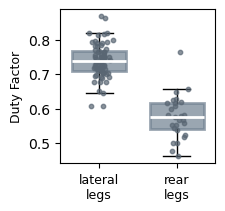

In [6]:
# boxplots for duty factor
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
lateral_duty = step_df[step_df.legID.isin(lateral_legs)]['duty'].values
rear_duty = step_df[step_df.legID.isin(rear_legs)]['duty'].values

f,ax = plt.subplots(figsize=(2,2))
ax, bp = colorBoxplot(ax, [lateral_duty, rear_duty], 
                      ['slategray','slategray'], 10, 0.8)
ax.set_xticks([1,2],['lateral\nlegs','rear\nlegs'], fontsize=tick_fontsize)
ax.set_ylabel('Duty Factor',fontsize=tick_fontsize)
# ax.set_ylim([-0.05, 1.05])
plt.show()

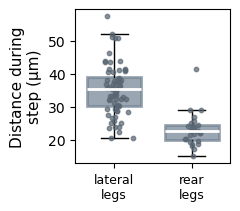

In [7]:
# boxplots for distance traveled
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
col = 'distance_during_step_scaled'
lateral_distance= step_df[step_df.legID.isin(lateral_legs)][col].values * 1000
rear_distance = step_df[step_df.legID.isin(rear_legs)][col].values * 1000

f,ax = plt.subplots(figsize=(2,2))
ax, bp = colorBoxplot(ax, [lateral_distance, rear_distance], 
                      ['slategray','slategray'], 10, 0.8)
ax.set_xticks([1,2],['lateral\nlegs','rear\nlegs'], fontsize=tick_fontsize)
ax.set_ylabel('Distance during\nstep (µm)',fontsize=axis_fontsize)
# ax.set_ylim([-0.05, 1.05])
plt.show()

# Diagram to define step kinematic parameters
### Stance Duration, Swing Duration
### Gait cycle, Duty Factor
### Anterior Offset, Opposite Offset

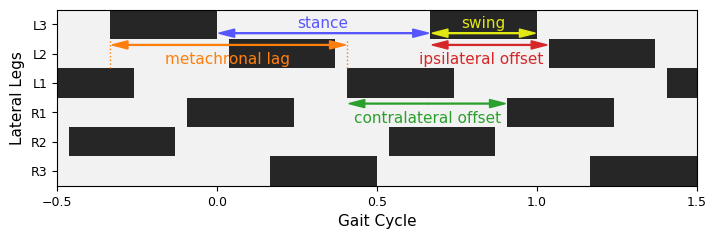

In [8]:
def annotatedStepDiagram(ax, add_mcl=True):
    
    num_legs = 6
    num_cycles = 3 
    duty_factor = 2/3 
    anterior_offset = 0.37
    opposite_offset = 1/2
    ax, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax, num_legs, num_cycles, duty_factor, anterior_offset, opposite_offset)

    # arrow parameters
    arrow_width = 0.03
    headwidth = 0.28
    headlength = 0.05
    arrow_buffer = 0.005

    # text label offsets
    stance_buffer = 0.082
    swing_buffer = 0.07
    ipsi_buffer = 0.22
    contra_buffer = 0.23
    mcl_buffer = 0.2

    # arrows and text for STANCE
    arrow_x = duty_factor / 2
    arrow_y = 6.2
    dx = duty_factor / 2 - arrow_buffer
    stance_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=stance_color)
    ax.add_patch(stance_arrow_right)
    stance_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=stance_color)
    ax.add_patch(stance_arrow_left)

    ax.text(arrow_x - stance_buffer, 6.4, 'stance', fontsize=axis_fontsize, color = stance_color)

    # arrows and text for SWING
    arrow_x = duty_factor + (1 - duty_factor)/2
    arrow_y = 6.2
    dx = ((1 - duty_factor) / 2) - arrow_buffer
    swing_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=swing_color)
    ax.add_patch(swing_arrow_right)
    swing_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=swing_color)
    ax.add_patch(swing_arrow_left)

    ax.text(arrow_x - swing_buffer, 6.4, 'swing', fontsize=axis_fontsize, color = swing_color)

    # arrows and text for IPSILATERAL OFFSET
    arrow_x = duty_factor + anterior_offset/2
    arrow_y = 5.8
    dx = (anterior_offset/2) - arrow_buffer
    anterior_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=ipsi_color)
    ax.add_patch(anterior_arrow_right)
    anterior_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=ipsi_color)
    ax.add_patch(anterior_arrow_left)

    ax.text(arrow_x - ipsi_buffer, 5.15, 'ipsilateral offset', fontsize=axis_fontsize, color=ipsi_color)

    # arrows and text for CONTRALATERAL OFFSET
    arrow_x = 2 * anterior_offset - (1-duty_factor) + opposite_offset/2
    arrow_y = 3.8
    dx = (opposite_offset/2) - arrow_buffer
    opposite_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=contra_color)
    ax.add_patch(opposite_arrow_right)
    opposite_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                width=arrow_width, length_includes_head=True, color=contra_color)
    ax.add_patch(opposite_arrow_left)

    ax.text(arrow_x - contra_buffer, 3.15, 'contralateral offset', fontsize=axis_fontsize, color=contra_color)
    
    if add_mcl:
        # arrows and text for METACHRONAL LAG
        mcl = 2 * anterior_offset
        mcl_start = - (1-duty_factor)
        mcl_end = - (1-duty_factor) + mcl
        arrow_x = mcl_start + mcl / 2
        arrow_y = 5.8
        dx = (mcl/2) - arrow_buffer
        mcl_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                                    width=arrow_width, length_includes_head=True, color=mcl_color)
        ax.add_patch(mcl_arrow_right)
        mcl_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                                    width=arrow_width, length_includes_head=True, color=mcl_color)
        ax.add_patch(mcl_arrow_left)
        # dashed lines for boundaries
        ax.plot([mcl_start,mcl_start],[5,6],':',color=mcl_color,linewidth=1)
        ax.plot([mcl_end,mcl_end],[5,6],':',color=mcl_color,linewidth=1)
        ax.text(arrow_x - mcl_buffer, 5.15, 'metachronal lag', fontsize=axis_fontsize, color=mcl_color)
    
    # axis limits and labels
    xlow = -0.5
    xhigh = 1.5
    ax.set_xlim([xlow, xhigh])
    ax.set_xticks(np.arange(xlow, xhigh+0.5, 0.5))
    
    return ax

f = plt.figure(figsize=(8,2.2))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax=annotatedStepDiagram(ax)
ax.set_ylabel('Lateral Legs', fontsize=axis_fontsize)
ax.xaxis.label.set_size(axis_fontsize)
ax.xaxis.set_tick_params(labelsize=tick_fontsize)
ax.yaxis.set_tick_params(labelsize=tick_fontsize)
plt.show()

11 11
Spearman  -0.42 , p = 0.2


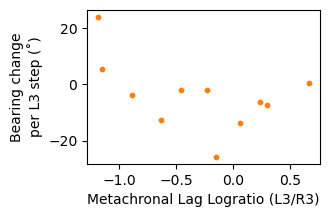

In [18]:
# metachronal lag vs. bearing change
mcl_ratios = gaitFunctions.omitNan(step_df['mcl_LR_ratio'].values)
l3_bearing_changes = gaitFunctions.omitNan(step_df['L3_bearing_change'].values)
print(len(mcl_ratios), len(l3_bearing_changes))
r,p = stats.spearmanr(mcl_ratios,l3_bearing_changes)
print('Spearman ', np.round(r,2), ', p =',np.round(p,2))
f,a = plt.subplots(1,1,figsize=(3,2))
if p < 0.05:
    sns.regplot(ax=a, x=mcl_ratios, y=l3_bearing_changes, scatter_kws={'s':marker_size,'color':mcl_color}, 
                    line_kws={'color':mcl_color,'linewidth':2})
else:
    a.scatter(mcl_ratios,l3_bearing_changes,s=marker_size,c=mcl_color)
a.set_xlabel('Metachronal Lag Logratio (L3/R3)')
a.set_ylabel('Bearing change\nper L3 step (˚)')

plt.show()

# Big figure showing step tracking for one clip

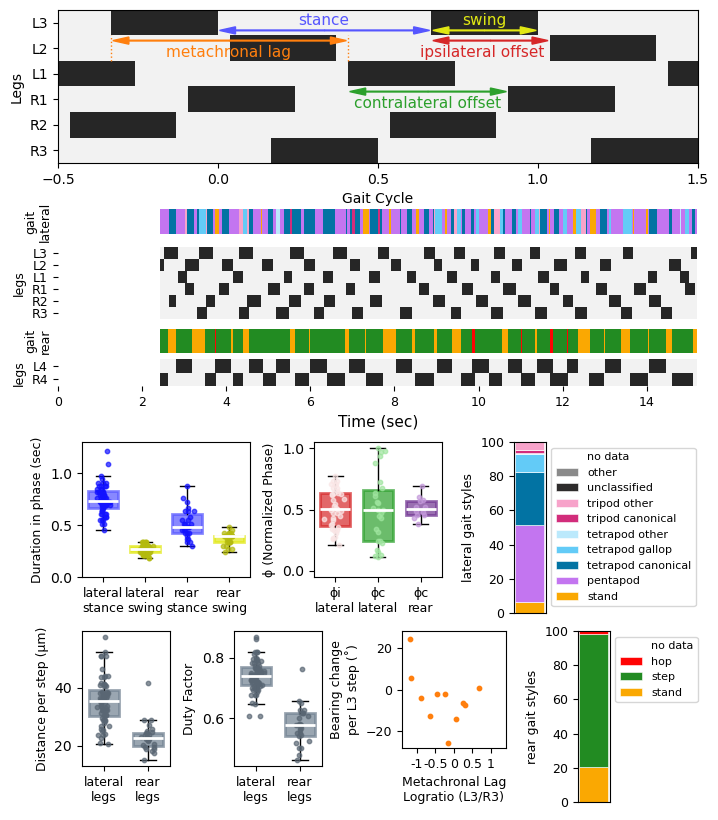

In [21]:
f = plt.figure(1, figsize=(8,9))

tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)
path_stats = gaitFunctions.loadPathStats(movie_file)
scale = float(path_stats['scale'])
unit = path_stats['unit']
last_frame = tracked_df.times.values[-1]
xlim = ([0,last_frame])

# set up axes locations
diagram_ax = f.add_axes([0.05,0.78,0.8,0.17])
lateralgaits_ax = f.add_axes([0.05, 0.7, 0.8, 0.03]) #+262
lateralsteps_ax = f.add_axes([0.05, 0.607, 0.8, 0.08])
reargaits_ax = f.add_axes([0.05, 0.567, 0.8, 0.03])
rearsteps_ax = f.add_axes([0.05, 0.532, 0.8, 0.03])

ss_ax =   f.add_axes([0.08, 0.32, 0.21, 0.15]) # stance & swing (all four)
offsets_ax = f.add_axes([0.37, 0.32, 0.16, 0.15]) # offsets (lat lat rear)

distancestep_ax = f.add_axes([0.08, 0.11, 0.11, 0.15]) # distance / step axis (lateral, rear)
duty_ax = f.add_axes([0.27, 0.11, 0.11, 0.15]) # duty (lat, rear)
mcl_ax = f.add_axes([0.48,0.13,0.13,0.13]) # metachronal lag vs bearings scatter

lateral_gait_proportions_ax = f.add_axes([0.62, 0.28, 0.04, 0.19])
rear_gait_proportions_ax = f.add_axes([0.7, 0.07, 0.04, 0.19])

# annotated step diagram
diagram_ax = annotatedStepDiagram(diagram_ax)

# plot the gait styles for lateral legs
lateralgaits_ax = gaitFunctions.plotGaits(lateralgaits_ax, excel_filename, 'lateral')
lateralgaits_ax.set_xlim(xlim)

# plot the steps for the lateral legs
lateral_legs = gaitFunctions.get_leg_combos()[0]['legs_lateral']
lateralsteps_ax = gaitFunctions.plotLegSet(lateralsteps_ax, movie_file, lateral_legs)
lateralsteps_ax.set_xlabel('')
lateralsteps_ax.set_xticks([])
lateralsteps_ax.set_xlim(xlim)

# plot the gait styles for rear legs
reargaits_ax = gaitFunctions.plotGaits(reargaits_ax, excel_filename, 'rear')
reargaits_ax.set_xlim(xlim)

# plot the steps for the rear legs
rear_legs = gaitFunctions.get_leg_combos()[0]['legs_4']
rearsteps_ax = gaitFunctions.plotLegSet(rearsteps_ax, movie_file, rear_legs)
rearsteps_ax.set_xlim(xlim)
# rear_steps.set_xticks([])

# distance per step for lateral legs and rear legs
lateral_legs = ['L3','L2','L1','R3','R2','R1']
rear_legs = ['L4','R4']
col = 'distance_during_step_scaled'
lateral_distance= step_df[step_df.legID.isin(lateral_legs)][col].values * 1000
rear_distance = step_df[step_df.legID.isin(rear_legs)][col].values * 1000
distancestep_ax, bp = colorBoxplot(distancestep_ax, [lateral_distance, rear_distance], 
                      ['slategray','slategray'], 10, 0.8)
distancestep_ax.set_xticks([1,2],['lateral\nlegs','rear\nlegs'], fontsize=tick_fontsize)
distancestep_ax.set_ylabel('Distance per step (µm)',fontsize=tick_fontsize)

# offsets
offsets_ax, bp = colorBoxplot(offsets_ax,[ipsi_proportions, contra_proportions, rear_proportions],
                  [ipsi_color, contra_color, rear_leg_color],10, 1.9)

offsets_ax.set_ylim([-0.05,1.05])
offsets_ax.set_ylabel('ϕ (Normalized Phase)', fontsize=tick_fontsize)
offsets_ax.set_xticks([1,2,3],['ϕi\nlateral', 'ϕc\nlateral','ϕc\nrear'], fontsize=tick_fontsize)

# stance and swing
ss_ax, bp = colorBoxplot(ss_ax, [lateral_stances, lateral_swings,rear_stances, rear_swings], 
                      [stance_color, swing_color, stance_color, swing_color],
                      10, 0.8)
ss_ax.set_xticks([1,2,3,4],['lateral\nstance','lateral\nswing','rear\nstance','rear\nswing'],
              fontsize=tick_fontsize)
ss_ax.set_ylabel('Duration in phase (sec)', fontsize=tick_fontsize)
ss_ax.set_ylim([0,1.3])

# duty factor
duty_ax, bp = colorBoxplot(duty_ax, [lateral_duty, rear_duty], 
                      ['slategray','slategray'], 10, 0.8)
duty_ax.set_xticks([1,2],['lateral\nlegs','rear\nlegs'], fontsize=tick_fontsize)
duty_ax.set_ylabel('Duty Factor',fontsize=tick_fontsize)

# metachronal lag vs. direction change (bearing change)
mcl_ax.scatter(mcl_ratios,l3_bearing_changes,s=marker_size,c=mcl_color)
# sns.regplot(ax=mcl_ax, x=mcl_ratios, y=l3_bearing_changes, scatter_kws={'s':marker_size,'color':mcl_color}, 
#                     line_kws={'color':mcl_color,'linewidth':2})
mcl_ax.set_xlabel('Metachronal Lag\nLogratio (L3/R3)', fontsize=tick_fontsize)
mcl_ax.set_ylabel('Bearing change\nper L3 step (˚)', fontsize=tick_fontsize)
mcl_ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
mcl_ax.set_ylim([-28,28])
mcl_ax.set_xlim([-1.4,1.4])
mcl_ax.set_xticks([-1,-0.5,0,0.5,1],[str(x) for x in [-1,-0.5,0,0.5,1]])

# proportions and legend for gait styles: lateral
lateral_gait_proportions_ax = gaitFunctions.gaitStylePercentagesPlot(lateral_gait_proportions_ax, 
                                                                      [excel_filename],
                                                                      'lateral')

# proportions and legend for gait styles: rear
rear_gait_proportions_ax = gaitFunctions.gaitStylePercentagesPlot(rear_gait_proportions_ax, 
                                                                      [excel_filename],
                                                                      'rear')
# adjust parameters and show plot
for ax in [lateralsteps_ax, rearsteps_ax, lateralgaits_ax, reargaits_ax]:
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
for ax in [lateral_gait_proportions_ax,rear_gait_proportions_ax]:
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
rearsteps_ax.xaxis.label.set_size(axis_fontsize)
rearsteps_ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
# show plot
plt.show()

# Legend Draft